In [1]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import hist, processor
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

/work/dvalsecc/miniconda3/envs/pocket-coffea/lib/python3.9/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [89]:
filename = "/pnfs/psi.ch/cms/trivcat/store/user/mmarcheg/RunIIFall17NanoAODv7/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/587E2464-42CA-3A45-BD49-D23E49F658E6.root"
#events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema).events()
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=400000).events()

In [4]:
events.Jet.rawFactor

<Array [[0.0635, 0.04, ... 0.336, 0.158]] type='100 * var * float32[parameters={...'>

In [5]:
SF = ak.flatten(1 - events.Jet.rawFactor)
SF

<Array [0.937, 0.96, 0.958, ... 0.664, 0.842] type='1098 * float32'>

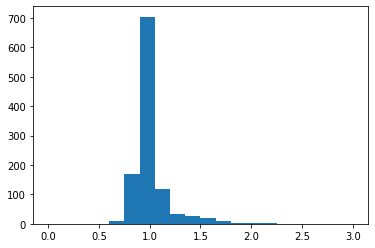

In [6]:
plt.hist(SF, bins=20, range=(0,3));

In [7]:
pt_raw = (1 - events.Jet['rawFactor']) * events.Jet['pt']

In [8]:
ratio = ak.flatten(events.Jet.pt/pt_raw)
ratio

<Array [1.07, 1.04, 1.04, ... 1.21, 1.51, 1.19] type='1098 * float32'>

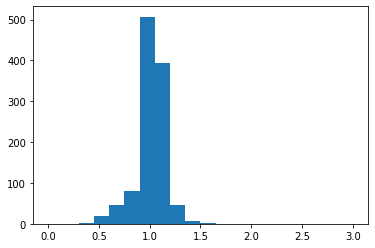

In [9]:
plt.hist(ratio, bins=20, range=(0,3));

(array([  0.,   0.,   0.,   0.,   9., 169., 704., 118.,  34.,  25.,  19.,
          9.,   4.,   4.,   2.,   0.,   1.,   0.,   0.,   0.]),
 array([0.  , 0.15, 0.3 , 0.45, 0.6 , 0.75, 0.9 , 1.05, 1.2 , 1.35, 1.5 ,
        1.65, 1.8 , 1.95, 2.1 , 2.25, 2.4 , 2.55, 2.7 , 2.85, 3.  ],
       dtype=float32),
 <BarContainer object of 20 artists>)

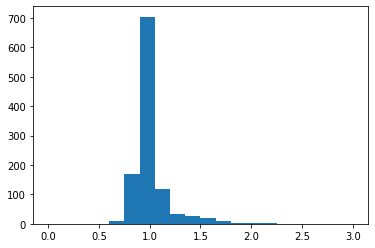

In [10]:
plt.hist(1/ratio, bins=20, range=(0,3))

# Testing the coffea implementation

In [37]:
import gzip

import cloudpickle

In [38]:
path = "../jets_evaluator.pkl"

In [39]:
with gzip.open(path) as fin:
        jmestuff = cloudpickle.load(fin)

In [44]:
def add_jec_variables(jets, event_rho):
    jets["pt_raw"] = (1 - jets.rawFactor)*jets.pt
    jets["mass_raw"] = (1 - jets.rawFactor)*jets.mass
    jets["pt_gen"] = ak.values_astype(ak.fill_none(jets.matched_gen.pt, 0), np.float32)
    jets["event_rho"] = ak.broadcast_arrays(event_rho, jets.pt)[0]
    return jets


In [83]:
import cachetools
jec_cache = cachetools.Cache(np.inf)

In [90]:
%%time
j = jmestuff["jet_factory"]["2018"].build(add_jec_variables(events.Jet,events.fixedGridRhoFastjetAll), jec_cache)

CPU times: user 4.06 s, sys: 438 ms, total: 4.5 s
Wall time: 4.49 s


In [103]:
j.fields

['area',
 'btagCMVA',
 'btagCSVV2',
 'btagDeepB',
 'btagDeepC',
 'btagDeepFlavB',
 'btagDeepFlavC',
 'chEmEF',
 'chFPV0EF',
 'chFPV1EF',
 'chFPV2EF',
 'chFPV3EF',
 'chHEF',
 'eta',
 'mass',
 'muEF',
 'muonSubtrFactor',
 'neEmEF',
 'neHEF',
 'phi',
 'pt',
 'puIdDisc',
 'qgl',
 'rawFactor',
 'bRegCorr',
 'bRegRes',
 'cRegCorr',
 'cRegRes',
 'electronIdx1',
 'electronIdx2',
 'jetId',
 'muonIdx1',
 'muonIdx2',
 'nConstituents',
 'nElectrons',
 'nMuons',
 'puId',
 'genJetIdx',
 'hadronFlavour',
 'partonFlavour',
 'cleanmask',
 'electronIdx1G',
 'electronIdx2G',
 'genJetIdxG',
 'muonIdx1G',
 'muonIdx2G',
 'muonIdxG',
 'electronIdxG',
 'pt_raw',
 'mass_raw',
 'pt_gen',
 'event_rho',
 'pt_orig',
 'mass_orig',
 'jet_energy_correction',
 'pt_jec',
 'mass_jec',
 'jet_energy_resolution',
 'jet_energy_resolution_scale_factor',
 'jet_resolution_rand_gauss',
 'jet_energy_resolution_correction',
 'pt_jer',
 'mass_jer',
 'JER',
 'jet_energy_uncertainty_FlavorQCD',
 'JES_FlavorQCD',
 'jet_energy_uncerta

In [86]:
%%time
j.JES_HF_2018.up.pt

CPU times: user 3.81 ms, sys: 0 ns, total: 3.81 ms
Wall time: 3.39 ms


<Array [[178, 94, 75.9, ... 22.2, 25, 23.4]] type='400000 * var * float32'>

Text(0.5, 0, 'Jets pt')

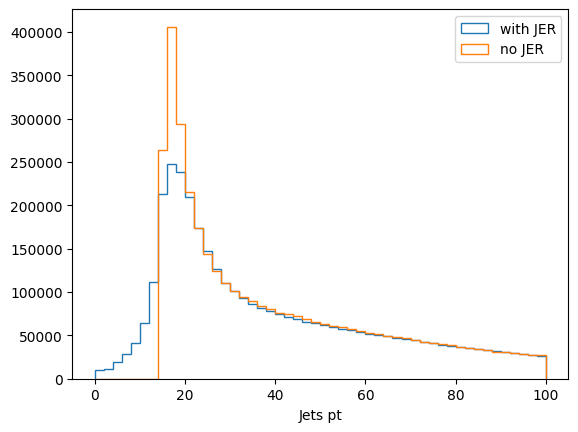

In [93]:
plt.hist(ak.flatten(j.pt), bins=50, range=(0,100), histtype="step", label="with JER")
plt.hist(ak.flatten(events.Jet.pt), bins=50, range=(0,100), histtype="step",label="no JER")
plt.legend()
plt.xlabel("Jets pt")

(array([ 11039.,  13818.,  24235.,  36152.,  49853.,  78287., 149886.,
        247230., 255970., 229251., 192016., 160199., 136065., 118373.,
        106003.,  97323.,  90028.,  84248.,  80024.,  76970.,  73153.,
         70420.,  68014.,  65194.,  62913.,  61074.,  58959.,  57185.,
         55294.,  53046.,  51664.,  49842.,  47987.,  46388.,  45223.,
         43309.,  41689.,  40407.,  38796.,  37766.,  36062.,  34896.,
         34008.,  32544.,  31003.,  29933.,  29405.,  27789.,  26699.,
         25998.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  92.,  94.,  96.,  98., 100.]),
 [<matplotlib.patches.Polygon at 0x7f97285e5190>])

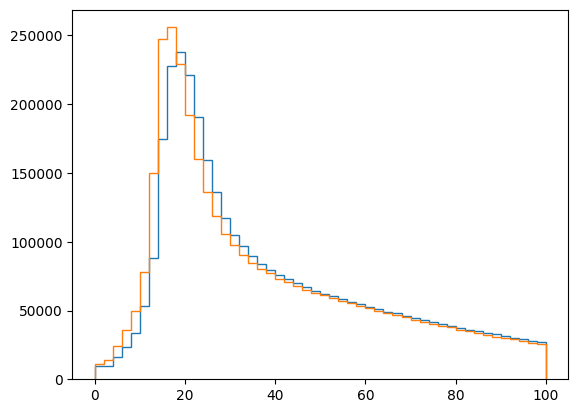

In [95]:
plt.hist(ak.flatten(j.JES_jes.up.pt), bins=50, range=(0,100), histtype="step")
plt.hist(ak.flatten(j.JES_jes.down.pt), bins=50, range=(0,100), histtype="step")

In [96]:
events["Jet"] = j.JES_jes.up

(array([  9419.,   9520.,  15891.,  23578.,  33505.,  53124.,  88488.,
        175039., 227541., 237822., 221191., 190696., 159588., 135980.,
        117390., 104570.,  96696.,  89866.,  83739.,  79227.,  75878.,
         72617.,  69942.,  66763.,  64502.,  62184.,  60499.,  58119.,
         56514.,  54766.,  52686.,  51045.,  49051.,  47998.,  46238.,
         44772.,  43138.,  41647.,  40153.,  38745.,  37402.,  36196.,
         34923.,  33923.,  32695.,  31263.,  30054.,  29398.,  27819.,
         27141.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  92.,  94.,  96.,  98., 100.]),
 [<matplotlib.patches.Polygon at 0x7f97283cc310>])

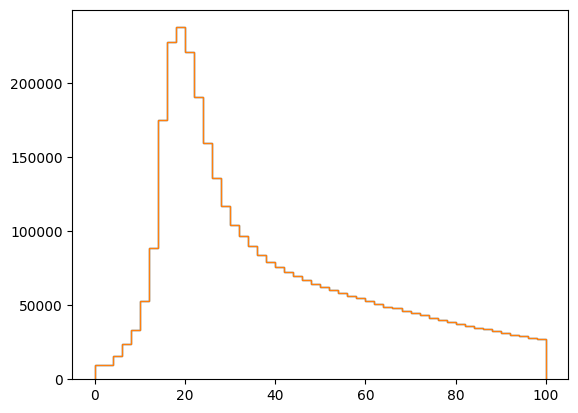

In [100]:
plt.hist(ak.flatten(j.JES_jes.up.pt), bins=50, range=(0,100), histtype="step")
plt.hist(ak.flatten(events.Jet.pt), bins=50, range=(0,100), histtype="step")